# US Presidential Elections from 1976 to 2020

Charting the history of US Presidential Election results from 1976 up to and including 2020.

### Contents:
* [The Idea of the Dashboard](#first_text)
* [The Data Used](#second_text)
* [The Design Choices in the Interactive Map Layers](#third_text)
* [The Design Choices in the Interactivity](#fourth_text)

## The Idea of the Dashboard <a class="anchor" id="first_text"></a>

The dashboard presents information on the results of US Presidential Elections from 1976 up to and including 2020. The idea of the dashboard is to provide an overview of each election result whilst also providing state-level results. The story is showing how the electoral geography has changed in the US over that period. There are many facets and stories within this, such as the following:

- At the start of the time period in 1976, the southern states typically voted Democrat, whereas in more recent decades they now typically vote Republican.
- The change in the politics of each state at a presidential election level over the time period is shown by the map.
- The poor performance of political parties which are neither the Democratic nor Republican parties is demonstrated in the dashboard.
- Some areas such as Washington D.C. have largely often voted for candidates from the same party over this time period.
- How presidential election turnout has changed in each state during this time period.

The dashboard shows how some states have become more Democrat dominated and other states have become more Republican dominated. The map and other elements within the dashboard attempt to communicate these stories to the user through them interacting with the dashboard. The dashboard allows users to view this data both at a national level and at a state-by-state level.


## Importing Libraries

These are the Python libraries imported.

In [1]:
import contextily as ctx
import folium
import geopandas as gpd
import hvplot.pandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import panel as pn
import plotly.express as px
pn.extension('plotly', design='material')

## The Data Used <a class="anchor" id="second_text"></a>

Two datasets were used for this project:
1. Cartographic Boundary Files from the United States Census Bureau (2018). These are in the form of shapefiles for each state in the US.
2. Presidential Election data from the 1976 election up to and including the 2020 election. This is from Kaggle (2021) and is in CSV format.

In [2]:
# Creating a GeoDataFrame from a shapefile of the US states.
states_gdf = gpd.read_file("States_shapefile.shp")
states_gdf.to_crs(epsg = "5070", inplace = True);

# Creating a GeoDataFrame from a CSV of US presidential election results.
pres_elect_hist_gdf = gpd.read_file("pres_elect_hist.csv")

The first dataset is being used as it is fundamental for displaying the shapes of each state on the interactive map. These shapes are polygons which cover the geographical area of each state. Polygons have been chosen rather than points as the data is not representing a single point within a state, but rather the state as a whole. The shapefiles for each state are also used for the smaller inset map on the dashboard to show the user which way the state they have selected voted in a specific election. The second dataset was chosen for three reasons. Firstly, it is in CSV format, therefore it is easy to import and process the data for web mapping using Python. Secondly, the data is on a state-by-state level enabling mapping for each individual state which complements the shapefiles in the first dataset. Thirdly, the dataset provides data for elections from 1976 up to and including 2020. This was unusual compared with many of the similar datasets which provided data for only one election each. This provided the advantage of not needing the import and process datasets for each individual election.

## Pre-processing the Data

The data from the two datasets goes through a pre-processing stage. This merges the two datasets together for mapping. It also processes the data so that the right data types are used and 'helper' columns are added to aid in presenting the information later used in the dashboard.

In [3]:
# Merging to two GeoDataFrames into one election history GeoDataFrame.
elect_hist_gdf = gpd.pd.merge(states_gdf, pres_elect_hist_gdf, how="left", left_on="State_Name", right_on="state")

# Setting the geometry of the eleciton history GeoDataFrame.
elect_hist_gdf = elect_hist_gdf.set_geometry("geometry_x")

# Dropping duplicated columns from the merged GeoDataFrame. 
elect_hist_gdf = elect_hist_gdf.drop(columns=["Program", "State_Code", "State_Name", "Flowing_St", "FID_1"])

# Changing the data types in the GeoDataFrame.
elect_hist_gdf["FID"] = elect_hist_gdf["FID"].astype(str)
elect_hist_gdf["state"] = elect_hist_gdf["state"].astype(str)
elect_hist_gdf["year"] = elect_hist_gdf["year"].astype("int64")
elect_hist_gdf["candidate"] = elect_hist_gdf["candidate"].astype(str)
elect_hist_gdf["party_detailed"] = elect_hist_gdf["party_detailed"].astype(str)
elect_hist_gdf["candidatevotes"] = elect_hist_gdf["candidatevotes"].astype("int64")
elect_hist_gdf["totalvotes"] = elect_hist_gdf["totalvotes"].astype("int64")

# Making an ID column.
elect_hist_gdf["id_str"] = elect_hist_gdf.index.astype(str)

# Creating a column for the percentage of each candidates votes.
percentage_list =[]
for votes, total_votes in zip(elect_hist_gdf["candidatevotes"], elect_hist_gdf["totalvotes"]):
    percentage_list.append(votes / total_votes * 100)
elect_hist_gdf["percentage_vote"] = percentage_list

# Creating a column for the colour of each candidate's political party.
party_colours = {
    "DEMOCRAT":"#3333FF",
    "LIBERTARIAN":"#FED105",
    "OTHER":"#263238",
    "REPUBLICAN":"#E81B23"
}
party_colour_list = []
for party in elect_hist_gdf["party_simplified"]:
    party_colour_list.append(party_colours[party])
elect_hist_gdf["party_colour"] = party_colour_list

# Updating blank candidate cells as they are for write-ins.
for candidate in elect_hist_gdf["candidate"]:
    if candidate == "":
        elect_hist_gdf.loc[elect_hist_gdf["candidate"] == "", "candidate"] = "Write-Ins"

## Further Data Processing

Further data processing takes place to identify the winning part in each state in each election.

In [4]:
# Creating a copy of the GeoDataFrame.
elect_hist_gdf_new = elect_hist_gdf.copy()

# Making a column to store the winning candidate votes for each state.
elect_hist_gdf_new["winning_candidate_votes"] = elect_hist_gdf_new.groupby(['year', 'state'])['candidatevotes'].transform('max')
# Checking if the values in the maximum column are the same as the votes in the candidate votes column.
equal_values_mask = elect_hist_gdf_new["winning_candidate_votes"] == elect_hist_gdf_new["candidatevotes"]
# Filtering the GeoDataFrame for only those which meet the condition above.
rows_with_equal_values = elect_hist_gdf_new[equal_values_mask]
# Setting a new column with the winning party in it.
elect_hist_gdf_new["winning_party"]= rows_with_equal_values["party_detailed"]
# Getting rid of the null rows, i.e. those not for the winning party.
for index, row in elect_hist_gdf_new.iterrows():
    if pd.isnull(row["winning_party"]):
        elect_hist_gdf_new = elect_hist_gdf_new.drop(index)

# Creating a column for the colour of each winning candidate's political party.
fill_colours_dict = {
    "DEMOCRAT":"#3333FF",
    "DEMOCRATIC-FARMER-LABOR":"#3484c2",
    "REPUBLICAN":"#E81B23"
}
winning_fill_colours = []
for party in elect_hist_gdf_new["winning_party"]:
    winning_fill_colours.append(fill_colours_dict[party])
elect_hist_gdf_new["winning_party_fill"] = winning_fill_colours

## Initial Maps

This map demonstrates the year slider changing a static map of the election result.

Column(design=<class 'panel.theme.materi...)
    [0] IntSlider(design=<class 'panel.theme.materi..., end=2020, name='Election Year', start=1976, step=4, value=1976)
    [1] ParamFunction(function, _pane=Matplotlib, defer_load=False, design=<class 'panel.theme.materi...)
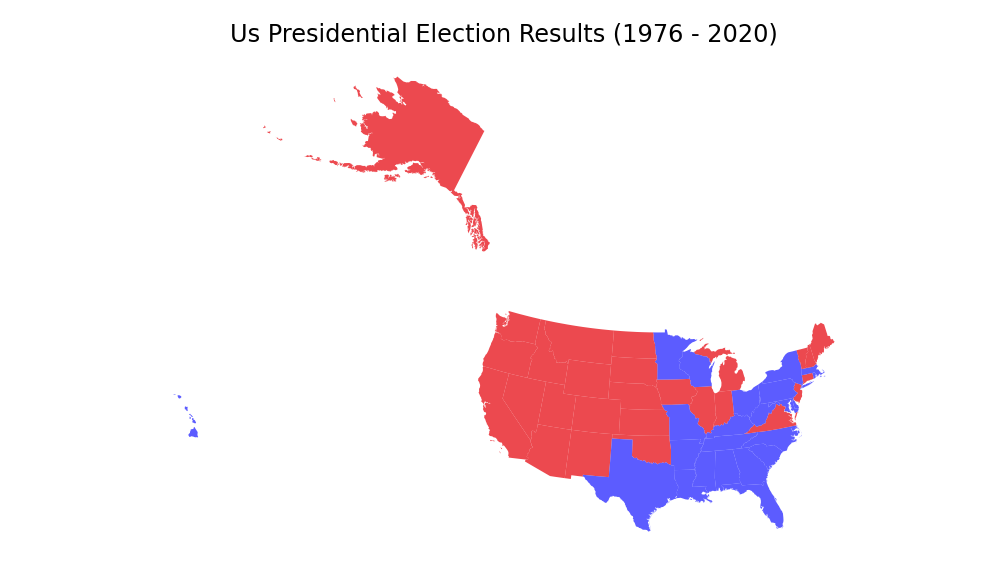

In [5]:
# Creating a test slider for choosing an election year.
test_year_selector = pn.widgets.IntSlider(name="Election Year", start = elect_hist_gdf_new.year.min(), end = elect_hist_gdf_new.year.max(), step = 4)

# Binding the test year slider.
@pn.depends(test_year_selector.param.value)
def update_test_map(year):
    """
    Creating a map of US presidential election results.

    This function creates a map of the US election results by state and party. 
    It changes based of off the year selector slider.

    Parameters:
        year: the year of the presidential election selected.

    Returns: 
        fig (map): the map showing the results in each state.
    
    """
    # Filtering the GeoDataFrame based off of the year aelected.
    filtered_df = elect_hist_gdf_new[elect_hist_gdf_new["year"] == year].copy()
    # Creating the map.
    fig, ax = plt.subplots(1, 1, figsize = (7, 4))
    filtered_df.plot(ax = ax,
                     alpha = 0.8,
                     color = filtered_df["winning_party_fill"])
    ax.set_axis_off()
    ax.set_title("Us Presidential Election Results (1976 - 2020)")
    fig.tight_layout()
    plt.close(fig)
    return fig

# Making the dashboard.
dashboard_test = pn.Column(test_year_selector, update_test_map)
# Displaying the dashboard.
dashboard_test.servable()

The below map shows all of the US Presidential Election from 1976 up to and including 2020. Each layer is trasnparent and overlayed on top of each other. This has the effect of indicating how Democratic or Republican each state has been over the whole time period. The more blue a state is the more Democratic it has voted, the more red a state is the more Republican it has voted. This demonstrates which states have remained static in their support for a party's candidate and which have changed often (the purple ones).

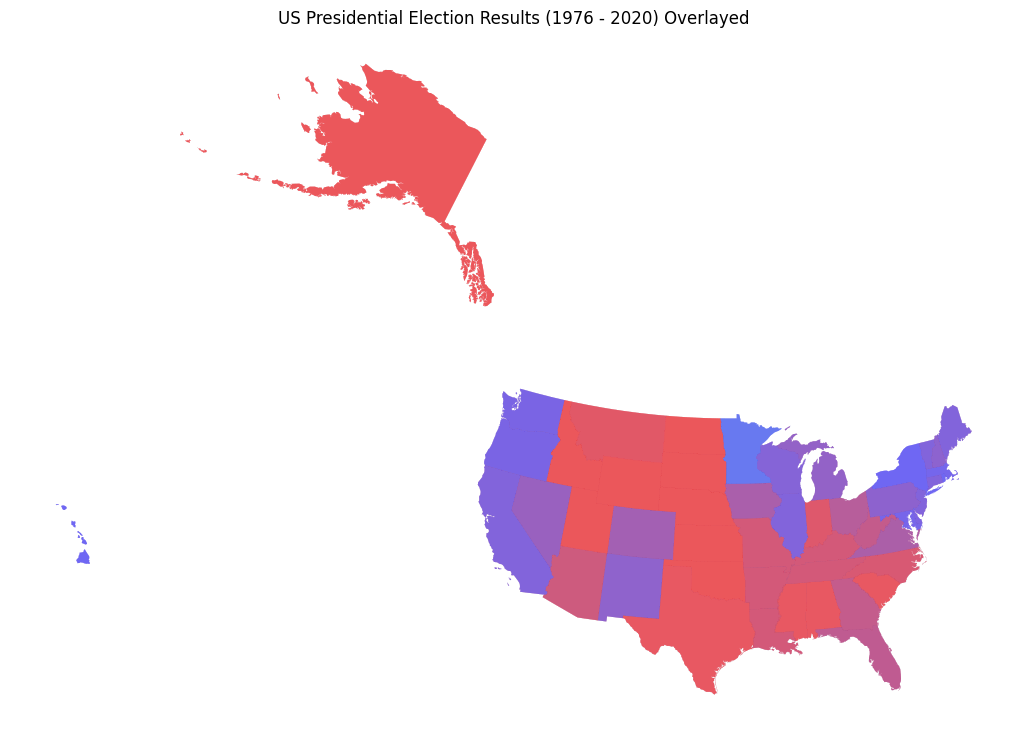

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (13, 10))
elect_hist_gdf_new.plot(ax = ax,
                        alpha = 0.1,
                        color = elect_hist_gdf_new["winning_party_fill"])
ax.set_axis_off()
ax.set_title("US Presidential Election Results (1976 - 2020) Overlayed");

## The Dashboard

## The Design Choices in the Interactive Map Layers <a class="anchor" id="third_text"></a>

There are two layers on the map:
1. A layer showing the colour of the winning candidate’s winning party in each state.
2. A layer showing the turnout in each state.

The first layer was selected as it is the most important piece of information to convey on the map. This is because the colour indicates who won in each state in each election. The colours are blue for the Democrats and red for the Republicans, these have been chosen as they are the colours typically associated with those parties. The second layer is a choropleth which shows the turnout in each state is there to add detail for the user and tell a related story. It shows the total turnout in terms of the number of people who voted, not the percentage. This shows how turnout has changed in each state relative to other states, this may be due to population change or a change in the proportion of people voting. The scale shown in the top right corner of the map demonstrates how turnout has grown during the time-period. A small inset map is above the interactive map. This shows the shape of the state selected and its colour is determined by the party of the candidate who won that state during the selected election.


Column(design=<class 'panel.theme.materi...)
    [0] Row(design=<class 'panel.theme.materi...)
        [0] Select(design=<class 'panel.theme.materi..., name='State', options=['ALABAMA', 'ALASKA', ...], value='ALABAMA')
        [1] IntSlider(design=<class 'panel.theme.materi..., end=2020, name='Election Year', start=1976, step=4, value=1976)
    [1] Row(design=<class 'panel.theme.materi...)
        [0] ParamFunction(function, _pane=Matplotlib, defer_load=False, design=<class 'panel.theme.materi...)
    [2] ParamFunction(function, _pane=HTML, defer_load=False, design=<class 'panel.theme.materi...)
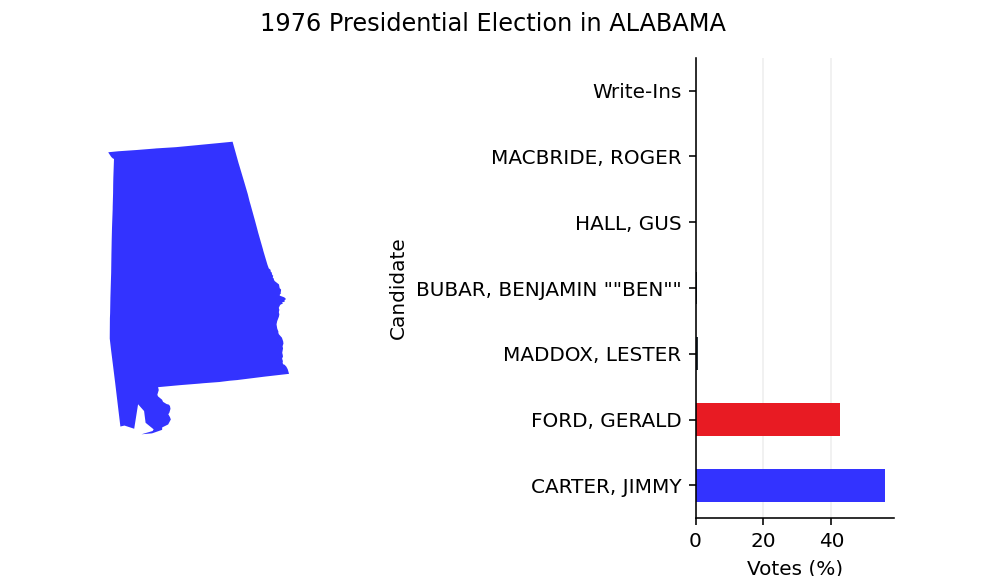

In [9]:
# Creating a slider for choosing an election year.
year_selector = pn.widgets.IntSlider(name='Election Year', start=elect_hist_gdf_new.year.min(), end=elect_hist_gdf_new.year.max(), step=4)
# Creating a drop-down to select a state.
states = list(elect_hist_gdf["state"].unique())
state_selector = pn.widgets.Select(name = "State", options = states)

# Binding the values from the year dropdown menu an
@pn.depends(year = year_selector.param.value, state = state_selector.param.value)
def state_plot(year, state):
    """
    This function creates the bar chart and small map.

    This function uses the state and year selected to create a bar chart showing 
    the percentage of votes for the candidates in a state during a presidential 
    election. It creates a map of that state coloured according to the party of 
    the winning candidate.

    Parameters:
        year: the year of the presidential election selected.
        state: the US state selected.
    

    Returns:
        fig (map/ bar chart): the small map and bar chart showing the percentage of votes for each candidate.
    
    """
    # Filtering the filtered DataFrame by state and year.
    data_state_filtered = elect_hist_gdf_new[elect_hist_gdf_new["state"] == state].copy()
    data_year_filtered = elect_hist_gdf_new[elect_hist_gdf_new["year"] == year].copy()
    data_state_year_filtered = pd.merge(data_state_filtered, 
                                        data_year_filtered, 
                                        how = "inner", 
                                        on = "id_str")
    # Setting the CRS again.
    wgs = "EPSG:5070"
    data_state_year_filtered.set_geometry("geometry_x_x", inplace=True)
    data_state_year_filtered = data_state_year_filtered.to_crs(wgs)
    # Creating the plot.
    fig, ax = plt.subplots(1, 2, figsize = (6.9, 4))
    # The small map.
    data_state_year_filtered.plot(ax = ax[0],
                                  color = data_state_year_filtered["winning_party_fill_y"],
                                  alpha = 1)
    ax[0].set_axis_off()
    # Filtering the original DataFrame by state and year.
    data_state = elect_hist_gdf[elect_hist_gdf["state"] == state].copy()
    data_year = elect_hist_gdf[elect_hist_gdf["year"] == year].copy()
    data_state_year = pd.merge(data_state, data_year, how = "inner", on = "id_str")
    # Setting the CRS again.
    wgs = "EPSG:5070"
    data_state_year.set_geometry("geometry_x_x", inplace=True)
    data_state_year = data_state_year.to_crs(wgs)
    # The bar chart.
    data_state_year[["candidate_x", "percentage_vote_y"]].plot(ax = ax[1],
                                                               color = data_state_year["party_colour_y"],
                                                               kind = "barh",
                                                               legend = False,
                                                               x = "candidate_x",
                                                               y = "percentage_vote_y")

    ax[1].set_xlabel("Votes (%)")
    ax[1].set_ylabel("Candidate")
    # Styling the plot.
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].xaxis.grid(True, color='#EEEEEE')
    ax[1].set_axisbelow(True)
    fig.suptitle(f"{year} Presidential Election in {state} ")
    plt.subplots_adjust(bottom = 0.1,
                        left = 0.1,
                        right = 0.9,
                        top = 0.9,
                        wspace = 2)
    plt.close(fig)
    return fig

def create_map(data):
    """
    Making the interactive map.

    This function creates the interactive map using Folium. It shows the 
    part of the winning candidate in each state and another layer shows 
    the turnout in each state.

    Parameters:
        data (Pandas DataFrame): This is a DataFrame with the electoral data.

    Returns:
        us_elections_map (folium map): This is the interactive map.
        
    """
    # Centering the map at the centre of the 'Contiguous United States' rather than the centre of the shape files.
    location = (39.77, -101.40)
    # Making the initial blank map.
    us_elections_map = folium.Map(control_scale = True, 
                                  location = location, 
                                  tiles = None,
                                  zoom_start = 4)
    # The turnout layer.
    turnout = folium.Choropleth(
        columns = ("id_str", "totalvotes"),
        data = data,
        fill_color = "Greys",
        fill_opacity = 0.7,
        geo_data = data,
        highlight = True,
        key_on = "feature.id",
        legend_name = "Turnout in the US Presidential Election",
        line_color = 'black',
        line_weight = 0.2,
        name = "Turnout",
        show = False
    )
    turnout.add_to(us_elections_map)
    # The party of th winning candidates in each state layer.
    winner = folium.GeoJson(
        data,
        fill_opacity = 0.5,
        highlight = True,
        key_on = "feature.id",
        line_color = 'black',
        line_weight = 0.1,
        name = "Party of the Winning Candidate",
        style_function = lambda x: {
            "fillColor": x["properties"]["winning_party_fill"],
        },
    )
    winner.add_to(us_elections_map)
    # The popup layer which diplays on click.
    popup = folium.GeoJsonPopup(
        fields = ["candidate", "party_simplified", "winning_candidate_votes", "percentage_vote","totalvotes"],
        aliases = ["Winning Candidate:", "Winning Party:", "Winning Candidate Votes:", "Winning Candidate % Votes:", "Total Votes Cast in State:"],
        labels = True,
        localize = True
    )
    # The tooltip layer which displays on hover.
    tooltip = folium.features.GeoJsonTooltip(fields = ("candidate",), 
                                             aliases = ("Candidate:",))
    tooltip_layer = folium.features.GeoJson(data,
                                            control = False,
                                            fill_opacity = 0,
                                            popup = popup,
                                            show = True,
                                            tooltip = tooltip)
    tooltip_layer.add_to(us_elections_map)
    # Controlling the layers.
    us_elections_map.keep_in_front(tooltip_layer)
    folium.LayerControl().add_to(us_elections_map)
    return us_elections_map

def update_map_state(df, state, year):
    """
    Updating the state of the interactive map.

    This function pre-processes the data for the interactive map. It also returns 
    the interactive map rendered as HTML.

    Parameters:
        df (Pandas DataFrame): This is a DataFrame with the electoral data.
        state: the US state selected.
        year: the year of the presidential election selected.

    Returns:
        folium_map (folium map): This is the interactive map rendered as HTML.
        
    """
    # Filtering the original DataFrame by state and year.
    data_state = elect_hist_gdf_new[elect_hist_gdf_new['state'] == state].copy()
    data_year = elect_hist_gdf_new[elect_hist_gdf_new['year'] == year].copy()
    data_state_year = pd.merge(data_state, 
                               data_year, 
                               how='inner', 
                               on='id_str')
    # Setting the CRS again.
    wgs = 'EPSG:5070'
    data_state_year.set_geometry("geometry_x_x", inplace=True)
    data_state_year = data_state_year.to_crs(wgs)
    # Calling the map function to create the interactive map.
    folium_map = create_map(data_year)
    # Rendering the map as HTML.
    return pn.pane.HTML(folium_map._repr_html_(), width=1000, height=500)

# Binding the values of the year and state selected for the interactive map.
map = pn.bind(update_map_state, elect_hist_gdf_new, state_selector.param.value, year_selector.param.value)
# Creating the dashboard's layout.
dashboard = pn.Column(
    pn.Row(state_selector, year_selector),
    pn.Row(state_plot),
    map
)
# Showing the dashboard.
dashboard.servable()

In [ ]:
# Exploring the dashboard
from bokeh.resources import INLINE
dashboard.save('dashboard_test.html', embed=True, resources=INLINE, max_opts = 10000)

# from IPython.display import HTML

# # Importing the dashboard as HTML
# with open('dashboard.html', 'r') as file:
#     html_content = file.read()
# HTML(html_content)

 64%|██████████████████████████▏              | 391/612 [11:47<06:17,  1.71s/it]

## The Design Choices in the Interactivity <a class="anchor" id="fourth_text"></a>

There are a number of elements of interactivity to the dashboard:
- Drop-down: The drop-down menu provides the user with the chance to select a specific state. This changes the small inset map and the horizontal bar chart at the top of the dashboard.
- Panning: The user can pan around the map to look at individual states, this is useful when zooming in on smaller states. It is also useful to pan to Alaska and Hawaii which are not shown on the map’s initial view as they are not part of the ‘Contiguous United States’ which the interactive map is centred on. Were the map centred in such a way that takes account for Alaska and Hawaii then the map would end up showing large parts of Canada and the Pacific Ocean which provide no additional data or information to the user.
- Slider: The slider changes the election year. It is in increments of four as there was a presidential election every four years. This changes all of the data shown to the user in the dashboard to the year that they have selected.
- Zooming: The user can zoom in and out on the interactive map. This is useful when zooming in on the smaller states such as Rhode Island and Delaware, as well as Washington D.C. Zooming out is also useful as it brings Alaska and Hawaii into view.

These elements of interactivity combine to allow the users of the dashboard to find the information that they desire.


## References

Kaggle (2021) US Elections Dataset [Online]. Available at: https://www.kaggle.com/datasets/tunguz/us-elections-dataset (Accessed 29th April 2024).

United States Census Bureau (2018) Cartographic Boundary Files - Shapefile [Online]. Available at: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html (Accessed 29th April 2024).